# Facial Keypoint Detection


In this project we are predicting 15 key features on human faces. Our dataset consists of 7039 images - all 96x96 and 30 coordinates of those features for each image (images are predictors).

First, it is required to upload the dataset to your Google Drive - "drive/My Drive/facial_keypoints_data/" 

Then you need to connect to the Google Drive from Colab by running the cell below.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Then we need to load libraries required for EDA, preprocessing and MultiOutput Regressors. They are all already installed in Colab.

In [0]:
import numpy as np 
import pandas as pd 
import os
import missingno as msno 

# For MultiOutput Regressors
import xgboost
from xgboost import plot_importance
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
from sklearn.model_selection import cross_val_score,KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

from sklearn.model_selection import train_test_split 
from sklearn.utils import shuffle
from matplotlib import pyplot as plt
%matplotlib inline 

checker = 0
for dirname, _, filenames in os.walk('drive/My Drive/facial_keypoints_data/'):
    for filename in filenames:
        if (os.path.join(dirname, filename) is not None): checker += 1
if checker == 4: print('All files are available')

# EDA

We start the EDA with loading the training set (whole data).

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')

In [0]:
training.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,7039.000000,7039.000000,7036.000000,7036.000000,2271.000000,2271.000000,2267.000000,2267.000000,2268.000000,2268.000000,2268.000000,2268.000000,2270.000000,2270.000000,2225.000000,2225.000000,2270.000000,2270.000000,2236.000000,2236.000000,7049.000000,7049.000000,2269.000000,2269.000000,2270.000000,2270.000000,2275.000000,2275.000000,7016.000000,7016.000000
mean,66.359021,37.651234,30.306102,37.976943,59.159339,37.944752,73.330478,37.707008,36.652607,37.989902,22.384504,38.033495,56.068513,29.332678,79.482826,29.734861,39.322137,29.502998,15.871177,30.428166,48.374186,62.715884,63.285735,75.970714,32.900404,76.179768,47.975412,72.919443,48.569472,78.970146
std,3.448233,3.152926,3.083230,3.033621,2.690354,2.307332,3.405852,2.881438,2.350268,2.311907,3.057122,2.910368,3.485485,3.078134,3.986224,3.773744,3.209641,3.106869,3.622533,3.865772,4.280038,5.720567,4.079063,4.579724,3.964552,4.417814,3.323060,5.222500,4.269961,5.407844
min,22.763345,1.616512,0.686592,4.091264,19.064954,27.190098,27.571879,26.250023,5.751046,26.250023,3.980117,25.123828,17.888717,15.859361,32.206432,10.522325,6.921014,16.476000,3.826243,13.224453,12.944699,17.932414,22.923362,57.023258,2.245766,56.690208,12.605173,56.719043,12.536477,25.850503
25%,65.082895,35.900451,28.783339,36.327681,58.039339,36.626283,71.716503,36.085523,35.506126,36.766783,20.585808,36.534382,54.515587,27.617244,77.673916,27.667948,37.552286,27.790607,13.562183,28.206046,46.602370,59.292697,61.257143,72.875707,30.797646,73.256472,46.494571,69.396748,46.573703,75.549715
50%,66.497566,37.528055,30.251378,37.813273,59.304615,37.878040,73.247824,37.639015,36.651562,37.944075,22.535954,37.867071,56.244975,29.528872,79.784229,29.773813,39.298848,29.569347,15.785709,30.320160,48.424713,63.451421,63.178286,75.778689,32.982305,76.000592,47.905490,72.605173,48.594978,78.696326
75%,68.024752,39.258449,31.768334,39.566729,60.519810,39.260348,75.015645,39.373489,37.753571,39.192917,24.237701,39.415051,57.946415,31.158830,81.590720,31.835621,40.917160,31.251664,17.999040,32.654768,50.330437,66.492686,65.376243,78.879123,35.101302,78.956357,49.296488,76.221644,50.677631,82.233993
max,94.689280,80.502649,85.039381,81.270911,84.440991,66.562559,95.258090,64.618230,70.714966,69.808803,61.428580,70.746797,79.787831,60.875896,94.269957,60.500298,76.582388,62.083177,58.418216,66.751329,89.438592,95.935644,84.767123,94.673637,74.017993,95.510678,83.989082,94.548359,89.438592,95.808983


Standard deviation is quite high - over 3 pixels in each feature, so simple algorithm based on means/medians would not work well.

How does y look like?

In [0]:
training.loc[:, training.columns != 'Image'].head()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774
1,64.332936,34.970077,29.949277,33.448715,58.856170,35.274349,70.722723,36.187166,36.034723,34.361532,24.472511,33.144443,53.987404,28.275949,78.634213,30.405923,42.728851,26.146043,16.865362,27.058860,48.206298,55.660936,56.421447,76.352000,35.122383,76.047660,46.684596,70.266553,45.467915,85.480170
2,65.057053,34.909642,30.903789,34.909642,59.412000,36.320968,70.984421,36.320968,37.678105,36.320968,24.976421,36.603221,55.742526,27.570947,78.887368,32.651621,42.193895,28.135453,16.791158,32.087116,47.557263,53.538947,60.822947,73.014316,33.726316,72.732000,47.274947,70.191789,47.274947,78.659368
3,65.225739,37.261774,32.023096,37.261774,60.003339,39.127179,72.314713,38.380967,37.618643,38.754115,25.307270,38.007903,56.433809,30.929864,77.910261,31.665725,41.671513,31.049990,20.458017,29.909343,51.885078,54.166539,65.598887,72.703722,37.245496,74.195478,50.303165,70.091687,51.561183,78.268383
4,66.725301,39.621261,32.244810,38.042032,58.565890,39.621261,72.515926,39.884466,36.982380,39.094852,22.506110,38.305237,57.249571,30.672177,77.762945,31.737247,38.035436,30.935382,15.925870,30.672177,43.299534,64.889521,60.671411,77.523239,31.191755,76.997301,44.962748,73.707387,44.227141,86.871166


How does X look like?

In [0]:
training['Image'].head(3)

0    238 236 237 238 240 240 239 241 241 243 240 23...
1    219 215 204 196 204 211 212 200 180 168 178 19...
2    144 142 159 180 188 188 184 180 167 132 84 59 ...
Name: Image, dtype: object

### Missing values



Check how many NAs are in each column




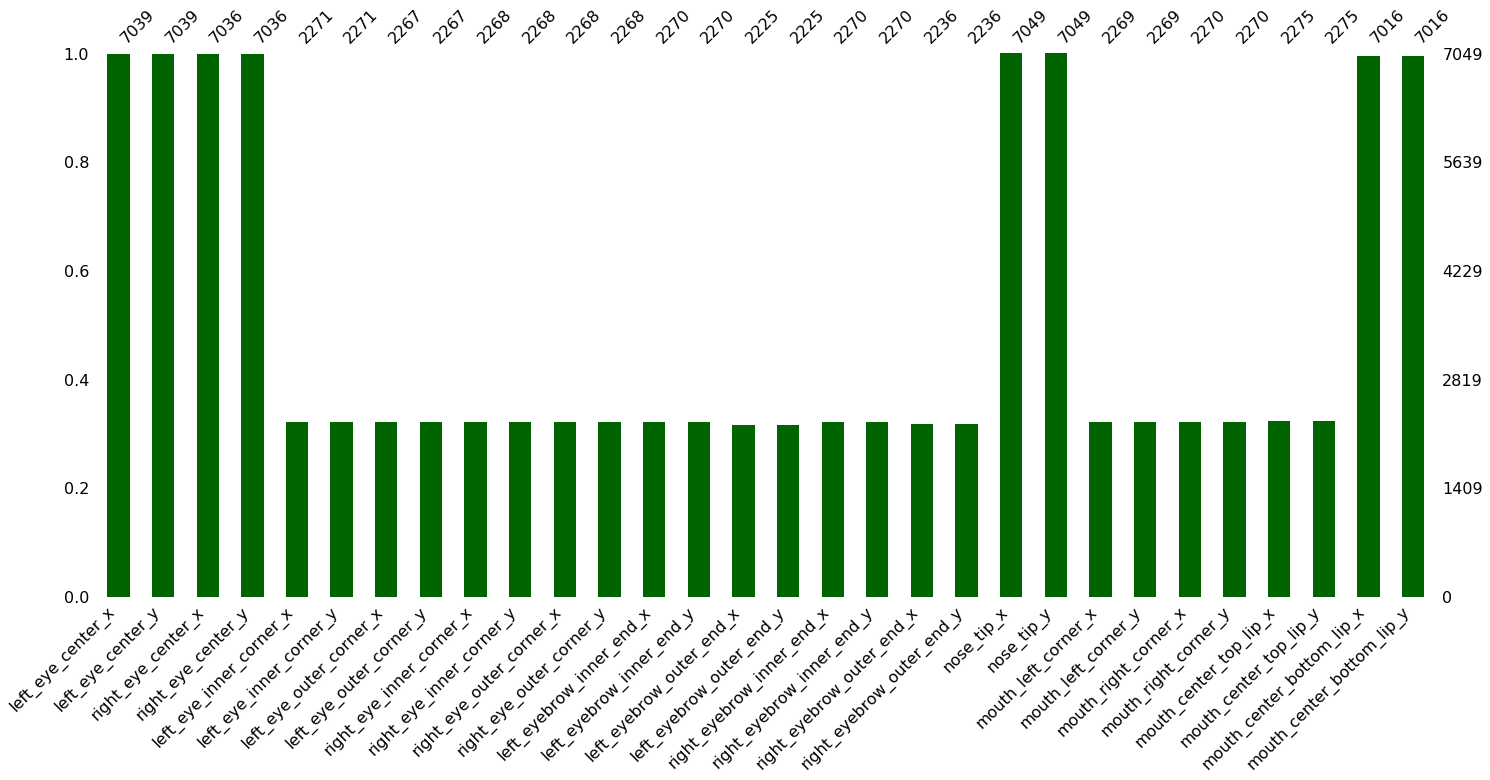

In [0]:
msno.bar(training[training.columns[:-1]], color='darkgreen') 

We can see that for most features only around 2200 observation have values. We decided to cut the missing values and use only those observations with all values.

### Drop NAs



In [0]:
training = training.dropna()

### Visualization


In [0]:
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, dtype=int, sep=' ').reshape((96,96)))

In [0]:
training['Image']

0       [[238, 236, 237, 238, 240, 240, 239, 241, 241,...
1       [[219, 215, 204, 196, 204, 211, 212, 200, 180,...
2       [[144, 142, 159, 180, 188, 188, 184, 180, 167,...
3       [[193, 192, 193, 194, 194, 194, 193, 192, 168,...
4       [[147, 148, 160, 196, 215, 214, 216, 217, 219,...
                              ...                        
7044    [[71, 74, 85, 105, 116, 128, 139, 150, 170, 18...
7045    [[60, 60, 62, 57, 55, 51, 49, 48, 50, 53, 56, ...
7046    [[74, 74, 74, 78, 79, 79, 79, 81, 77, 78, 80, ...
7047    [[254, 254, 254, 254, 254, 238, 193, 145, 121,...
7048    [[53, 62, 67, 76, 86, 91, 97, 105, 105, 106, 1...
Name: Image, Length: 7049, dtype: object

In [0]:
def get_image_and_dots(df, index):
    image = plt.imshow(df['Image'][index],cmap='gray')
    l = []
    for i in range(1,31,2):
        l.append(plt.plot(df.loc[index][i-1], df.loc[index][i], 'ro'))
        
    return image, l

def plot_faces(plot_dim = 6):
  fig = plt.figure(figsize=(12, 12))
  fig.subplots_adjust(
      left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

  for i in range(plot_dim*plot_dim):
      ax = fig.add_subplot(plot_dim, plot_dim, i + 1, xticks=[], yticks=[])
      get_image_and_dots(training, i)
      
  plt.show()

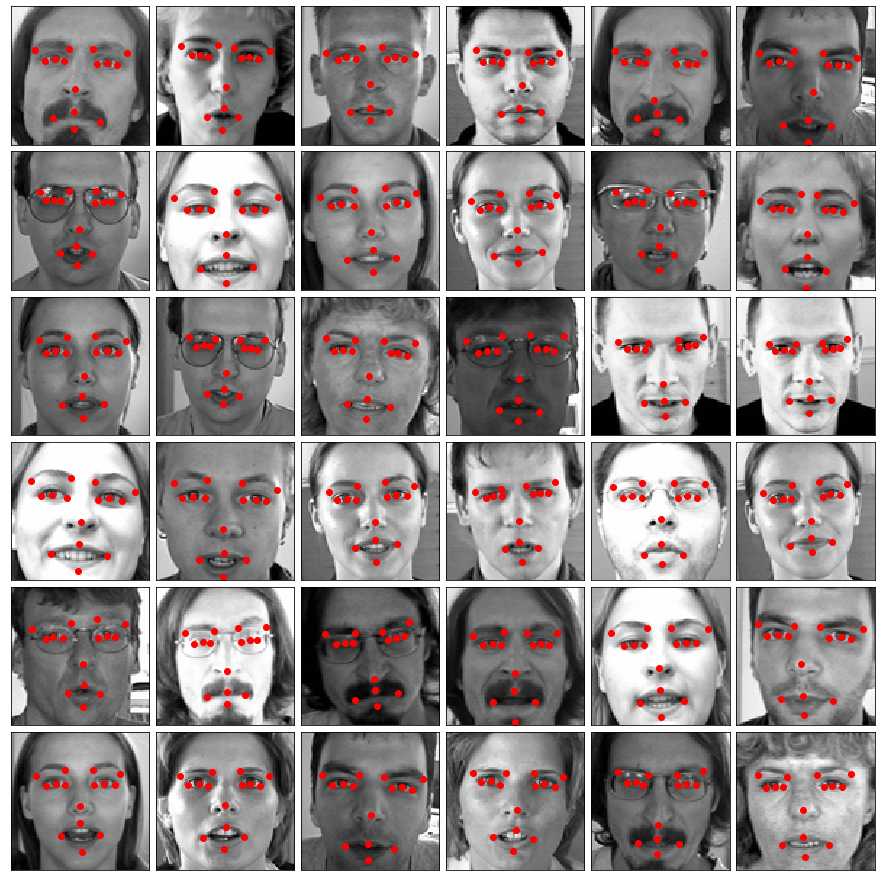

In [0]:
plot_faces(6)

# Preprocessing



### Creating X and y

In [0]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
training['Image'] = training['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training = training.dropna()

# scale pixel values to [0, 1]
X = np.vstack(training['Image'].values) / 255.
X = X.astype(np.float32)

y = training[training.columns[:-1]].values
# scale target coordinates to [-1, 1]
y = (y - 48) / 48  
X, y = shuffle(X, y, random_state=42)
y = y.astype(np.float32)

### Train and test split

Now we need to create train and test sets for all models, we use 15% of the data for the test set

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

# RMSE definition

We define our own loss - Root Mean Squared Error, because Keras does not have it implemented (this metric is used in this Kaggle Challenge.

In [0]:
from tensorflow.keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

# Saving model function

In [0]:
from tensorflow.keras.models import model_from_json

def save_model(model,name):
    json_string = model.to_json()
    open('drive/My Drive/'+name+'_architecture.json', 'w').write(json_string)
    model.save_weights('drive/My Drive/'+name+'_weights.h5')
    
def load_model(name):
    model = model_from_json(open('drive/My Drive/'+name+'_architecture.json').read())
    model.load_weights('drive/My Drive/'+name +'_weights.h5')
    return(model)

# **1st Multi Output Regressors**

## 1.1 Linear Regression

### Fitting the model

In [0]:
lm_model = MultiOutputRegressor(LinearRegression())
lm_model.fit(X_train, y_train)

### Prediction

In [0]:
lm_predict = lm_model.predict(X_test)

lm_acc = mean_squared_error(y_test, lm_predict)
lm = round(np.sqrt(lm_acc) * 48, 3)
print(lm_acc)
print(lm)


## 1.2 Decision Tree

### Fitting the model

In [0]:
dt_model = MultiOutputRegressor(DecisionTreeRegressor())
dt_model.fit(X_train, y_train)

### Prediction

In [0]:
dt_predict = dt_model.predict(X_test)

# evaluate predictions
dt_acc = mean_squared_error(y_test, dt_predict)
dt = round(np.sqrt(dt_acc) * 48, 3)
print(dt_acc)
print(dt)

## 1.3 Tuned Decision Tree

### Fitting the model

In [0]:
grid_tree = MultiOutputRegressor(DecisionTreeRegressor(max_depth = 20, min_samples_split = 2, min_samples_leaf = 20))
grid_tree.fit(X_train, y_train)

### Prediction

In [0]:
grid_tree_predict = grid_tree.predict(X_test)

# evaluate predictions
grid_tree_acc = mean_squared_error(y_test, grid_tree_predict)
gt = round(np.sqrt(grid_tree_acc) * 48, 3)
print(grid_tree_acc)
print(gt)

## 1.4 XGBoost

### Fitting the model

In [0]:
xgb_model = MultiOutputRegressor(xgboost.XGBRegressor(objective = "reg:squarederror"))

xgb_model.fit(X_train, y_train)

### Prediction

In [0]:
xgb_predict = xgb_model.predict(X_test)

# evaluate predictions
xgb_acc = mean_squared_error(y_test, xgb_predict)
xgb = round(np.sqrt(xgb_acc) * 48, 3)
print(xgb_acc)
print(xgb)


# **2nd Model - MLP**



In the next step we will implement simple Multilayer Perceptron that would act as a challenger for the following neural networks.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import SGD

In [0]:
model_mlp = Sequential([
  Dense(256, input_dim=X_train.shape[1], activation = 'relu'),
  Dropout(0.1),

  Dense(128, activation = 'relu'),
  Dropout(0.3),
  
  Dense(64, activation = 'relu'),
  Dense(30)
])

model_mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 256)               2359552   
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 30)                1950      
Total params: 2,402,654
Trainable params: 2,402,654
Non-trainable params: 0
____________________________________________

Below we can see the graph of the network.

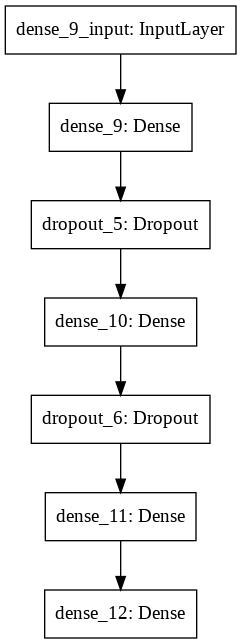

In [0]:
from keras.utils import plot_model
plot_model(model_mlp, to_file='drive/My Drive/facial_keypoints_data/mlp_rmse_2249.png')

### MLP training

We used Stochastic Gradient Descent and trained the network for 500 epochs with validation set consitsing of 10% of the training set.

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_mlp.compile(loss = root_mean_squared_error,
              optimizer = sgd)

hist_mlp = model_mlp.fit(X_train,
                     y_train,
                     epochs=500,
                     batch_size=128,
                     validation_split=0.1,
                     verbose=0)
print('Model trained')

Model trained


### Loss visualization

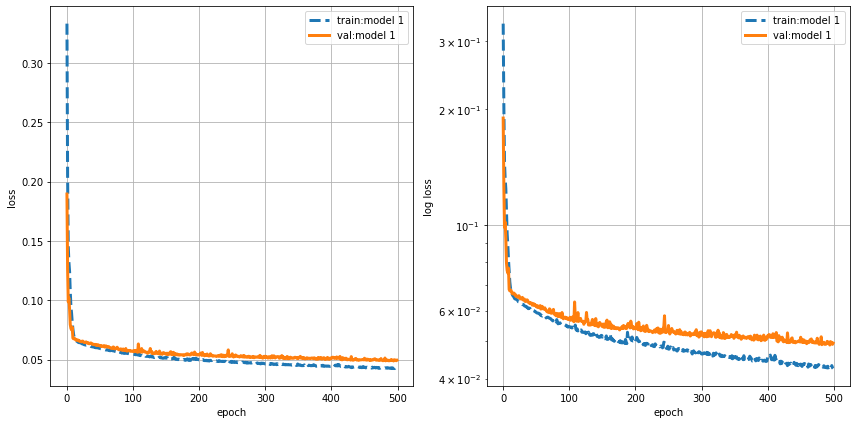

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_mlp.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
# plt.savefig('drive/My Drive/MLP_loss.png', bbox_inches='tight')
plt.show()

As we can see the learning curve looks really promising. Our network is slightly overfitting the training set, however loss on validation still decreases up till the end.

In [0]:
loss_eval = model_mlp.evaluate(X_test, y_test, batch_size=128)
print('Test loss(RMSE):', loss_eval)
print('Rescaled RMSE:', round(loss_eval * 48, 3))

321/321 [==============================] - 0s 79us/step
Test loss(RMSE): 0.046859319672870485
Rescaled RMSE: 2.249


Final score for the MLP network is really great: 2.249 (RMSE) makes a great challenger for the following CNNs.

### Saving model and weights

In [0]:
save_model(model_mlp,"model_mlp_2249")
model_mlp = load_model("model_mlp_2249")

# **3rd Model - CNN**

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import SGD

Preprocessing for CNN (reshaping from 1d vector)



We need to reshape our data for the following CNN.

In [0]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)

We created our own callbacks for training monitoring.

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.04 or logs.get('loss') < 0.02):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

We started with a very deep CNN, however it totally overfitted the trainig set so we cut a few convolutions blocks and added a few droput layers to prevent that. We also use "same" padding to keep the dimensions between the layers.

In [0]:
model_cnn = Sequential([
  Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)),
  LeakyReLU(alpha = 0.1),

  Conv2D(32, (3,3), padding='same'),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3,3), padding='same'),
  LeakyReLU(alpha = 0.1),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  
  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(256, (3,3),padding='same',use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Conv2D(512, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),

  Flatten(),
  Dense(512,activation='relu'),
  Dropout(0.1),
  Dense(30)
])

model_cnn.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_36 (Conv2D)           (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu_36 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 96, 96, 32)        9248      
_________________________________________________________________
leaky_re_lu_37 (LeakyReLU)   (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 48, 48, 64)        18496     
_________________________________________________________________
leaky_re_lu_38 (LeakyReLU)   (None, 48, 48, 64)       

You can analyze the network structure on the graph below.

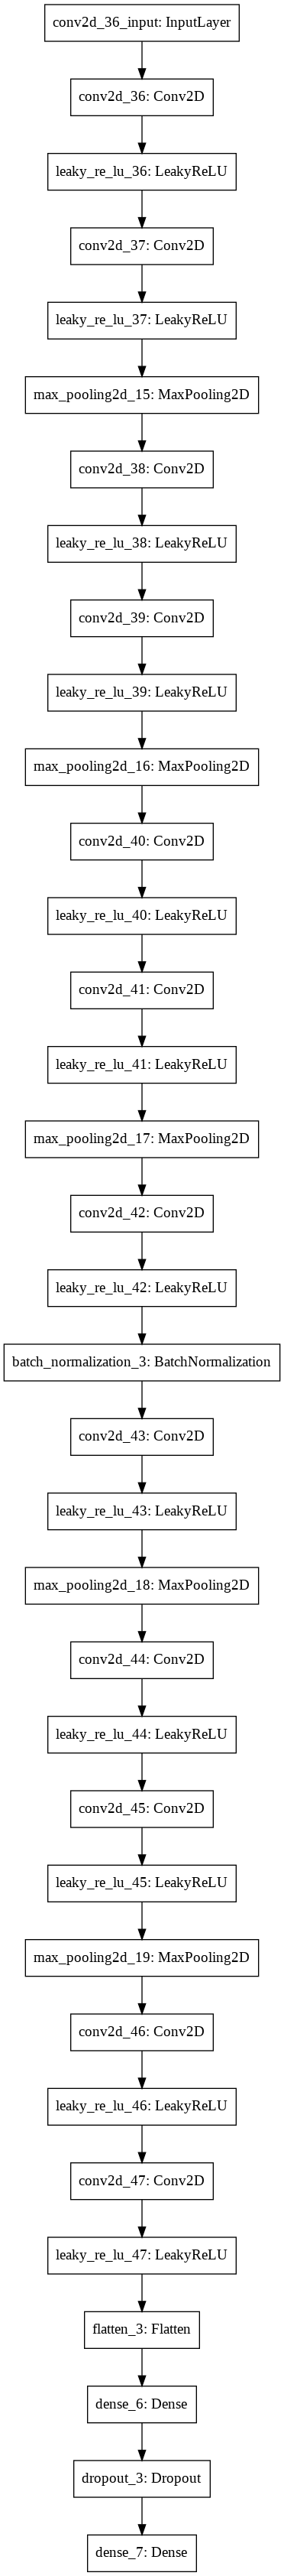

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn, to_file='drive/My Drive/facial_keypoints_data/cnn_rmse_1773.png')

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_cnn.compile(loss = root_mean_squared_error,
              optimizer = sgd)

We also used SGD for training this network, however this time we used callbacks to monitor training process and stop the training when defined loss is obtained - that would ensure that the network did not overfitt the training set.

In [0]:
hist_cnn = model_cnn.fit(X_train,
                         y_train,
                         epochs=600,
                         batch_size=128,
                         validation_split=0.1,
                         verbose = 0,
                         callbacks=[callbacks]
                        )

Epoch 1
Loss :0.12763452021975158 -- Val Loss: 0.31327661871910095

Epoch 11
Loss :0.06840839235609307 -- Val Loss: 0.264931457055794

Epoch 21
Loss :0.059788789079002876 -- Val Loss: 0.22972629096481825

Epoch 31
Loss :0.05338935587935209 -- Val Loss: 0.16841425394618903

Epoch 41
Loss :0.046366402384396654 -- Val Loss: 0.10052916473084754

Epoch 51
Loss :0.04366268357518029 -- Val Loss: 0.0607925092617234

Epoch 61
Loss :0.04023476888948486 -- Val Loss: 0.04503280235515846

Epoch 71
Loss :0.036721730444332266 -- Val Loss: 0.04682731370513256

Epoch 81
Loss :0.03361785313525285 -- Val Loss: 0.04339196053998811

Epoch 91
Loss :0.03079077101010481 -- Val Loss: 0.04443936704934298

Epoch 101
Loss :0.03023167135092676 -- Val Loss: 0.042826540154087676

Epoch 111
Loss :0.027903973840054174 -- Val Loss: 0.043160052540210575

Epoch 121
Loss :0.026509574485320323 -- Val Loss: 0.04220050409599975

Epoch 131
Loss :0.0254330657804857 -- Val Loss: 0.04148495008984765

Epoch 141
Loss :0.0243582710

### Saving model and weights

In [0]:
save_model(model_cnn,"model_cnn_1773")
model_cnn = load_model("model_cnn_1773")

### Loss visualization

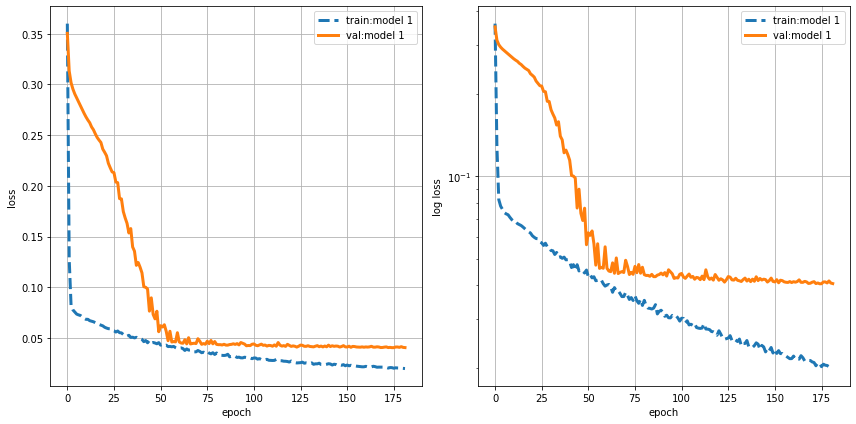

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
plt.savefig('drive/My Drive/CNN_loss.png', bbox_inches='tight')
plt.show()

We can see that in the begining the network did really bad on the validation set, but after around 50 epoch it finally reached the state in which it predicted the features in decent way. Unfortunately it didn't improve on the validation set - but that did not mean that it will perfom badly on the test set. Finally it achieved a loss on the training set below 1 RMSE!

### Evaluation

In [0]:
score = model_cnn.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', round(score*48, 3))

Test RMSE: 0.036929980819795365
Rescaled RMSE: 1.773


As we can see the test RMSE is great - 1.773!

In [0]:
y_eval = model_cnn.predict(X_test)

### Plotting predicted and real

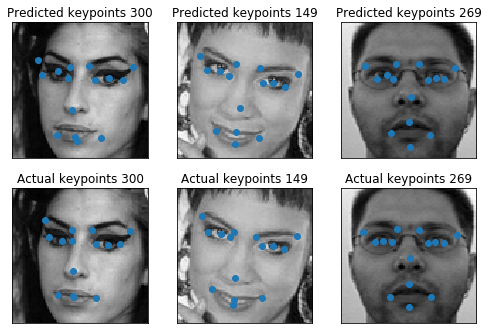

In [0]:
def plot_sample(X,y,axs):
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

fig = plt.figure(figsize=(7, 7))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
picture_id = [300,149,269]

for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_eval[ipic],ax)
    ax.set_title("Predicted keypoints "+ str(ipic))
    count += 1


for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("Actual keypoints "+ str(ipic))
    count += 1

plt.tight_layout()
# plt.savefig('drive/My Drive/CNN_faces_test_eval.png', bbox_inches='tight')
plt.show()

Finally the predictions looks really promising, but the network did not predict well on the tilted faces like the one in the center above - maybe we can improve that?

# **4th Model - CNN with transfer learning**

Our next idea was to use the knowledge from the observations that we omitted by droping NAs rows. We achieved that by training two CNNs - one for 8 features with almost 7000 observations and another one which used the weights and layers from the first one on the training set that the previous models used.

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, AvgPool2D, BatchNormalization, Dropout, Activation, MaxPool2D, LeakyReLU, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback

## First CNN (with 8 coordinates)

### Preprocessing for CNN with few features

We had to split the data into three datasets: final test set, training with all features (the same as previously) and the set with all observations but only with 8 features (that had values for every observation).

In [6]:
training = pd.read_csv('drive/My Drive/facial_keypoints_data/training/training.csv')
training.shape

(7049, 31)

Subset of all features (no NAs):


In [7]:
training_all_features = training.dropna()
training_all_features.shape

(2140, 31)

Subset with 8 features and images:

In [8]:
df_all = training.merge(training_all_features.drop_duplicates(), on=['Image'], 
                   how='left', indicator=True)
training_few_features = df_all[df_all['_merge'] == 'left_only'].iloc[:,0:31]
training_few_features = training_few_features.dropna(axis=1, thresh=len(training_few_features) - 34)
training_few_features.shape

(4908, 9)

Separating test set (for final model) from training_all_features

In [9]:
training_all_features = shuffle(training_all_features, random_state=666)
test_final = training_all_features.head(300)
training_all_features = training_all_features.tail(len(training_all_features) - 300)
training_all_features.shape

(1840, 31)

Combining training_few_features with training_all_features

In [10]:
print(training_few_features.shape)
print(training_all_features.shape)

(4908, 9)
(1840, 31)


In [0]:
training_few_features.columns = ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']

In [12]:
training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']].shape

(1840, 9)

In [0]:
training_cnn = pd.concat([training_few_features, training_all_features[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']]])

In [14]:
training_cnn.shape

(6748, 9)

### Train/test split for CNN with few features

We normalized and scaled all sets for the training.

In [0]:
training_cnn['Image'] = training_cnn['Image'].apply(lambda x: np.fromstring(x, sep=' '))
training_cnn = training_cnn.dropna()
# scale pixel values to [0, 1]
X = np.vstack(training_cnn['Image'].values) / 255.
X = X.astype(np.float32)

y = training_cnn[training_cnn.columns[:-1]].values
y = (y - 48) / 48  # scale target coordinates to [-1, 1]
X, y = shuffle(X, y, random_state=42)  # shuffle train data
y = y.astype(np.float32)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=666)

In [17]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(5694, 96, 96, 1)
(1005, 96, 96, 1)


### CNN with few features training

Our first CNN for 8 features isn't deep because we wanted to add more convolutions in the second network - however to obtain decent results we had to use a few MaxPooling layers that decrease the dimensions and if we would use more the output would finnaly be 1x1x(something big) and that would prevent any convolution following this network layers.

The process of learning is actually quite similar to the previous CNN.

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.04 or logs.get('loss') < 0.03):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

In [19]:
model_cnn_ff = Sequential([
  Conv2D(32, (3,3), padding='same', use_bias=False, input_shape=(96,96,1)),
  LeakyReLU(alpha = 0.1),

  Conv2D(32, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  Dropout(0.1),

  Conv2D(64, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  Dropout(0.1),
  
  Conv2D(96, (3,3), padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  BatchNormalization(),
  Dropout(0.1),

  Conv2D(128, (3,3),padding='same', use_bias=False),
  LeakyReLU(alpha = 0.1),
  MaxPool2D(pool_size=(2, 2)),

  Flatten(),
  Dense(256,activation='relu'),
  Dropout(0.1),
  Dense(8)
])

model_cnn_ff.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn_ff, to_file='drive/My Drive/facial_keypoints_data/cnn_ff_rmse_1773.png')

In [0]:
sgd = SGD(lr=0.01,
          momentum=0.9,
          nesterov=True)

model_cnn_ff.compile(loss = root_mean_squared_error,
              optimizer = sgd)

In [21]:
hist_cnn_ff = model_cnn_ff.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 0,
                        callbacks=[callbacks]
                     )

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1
Loss :0.08785018860526052 -- Val Loss: 0.15244424238539578

Epoch 11
Loss :0.07138460853619095 -- Val Loss: 0.1161173206149486

Epoch 21
Loss :0.05882175363291994 -- Val Loss: 0.06480261563209065

Epoch 31
Loss :0.05300696760962756 -- Val Loss: 0.051170564717368076

Epoch 41
Loss :0.049061803006153384 -- Val Loss: 0.04875132207546318

Epoch 51
Loss :0.04638628661923349 -- Val Loss: 0.046292672606936675

Epoch 61
Loss :0.04395100101828575 -- Val Loss: 0.04649114198329156

Epoch 71
Loss :0.04227105663925014 -- Val Loss: 0.04902308359742165

Epoch 81
Loss :0.03991992627092398 -- Val Loss: 0.04389651473938373

Epoch 91
Loss :0.03792693832660912 -- Val Loss: 0.043549013595309174

Epoch 101
Loss :0.03663196725295355 -- Val Loss: 0.045456640801408835

Epoch 111
Loss :0.035570101537665384 -- Val Loss: 0.044866324189985006

Epoch 121
Loss :0.034732959614913975 -- Val Loss: 0.0434876834744947

E

#### Loss visualization

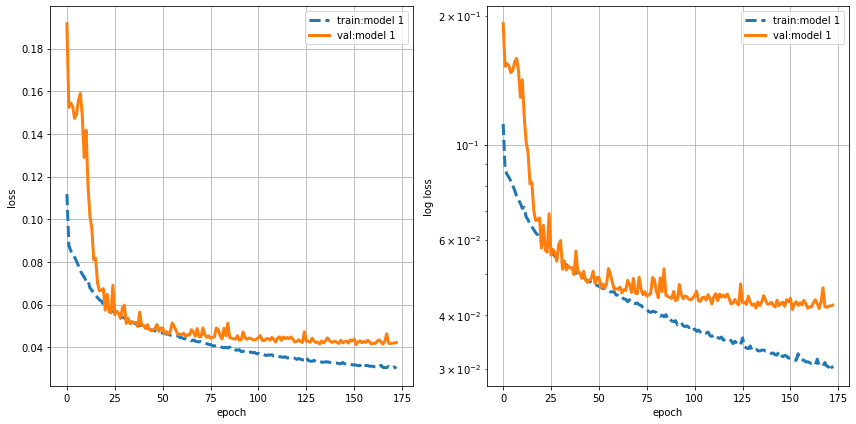

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn_ff.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.tight_layout()
plt.savefig('drive/My Drive/CNN_ff_loss.png', bbox_inches='tight')
plt.show()

As we can see the CNN learning curve looks quite similar to the last CNN - poor performance in the begining on the validation set and slight overfitt in the end.

#### Evaluation

In [23]:
score = model_cnn_ff.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
print('Rescaled RMSE:', score*48)

Test RMSE: 0.04411416341786954
Rescaled RMSE: 2.117479844057738


After 171 epochs the network achieved a great score of RMSE 2.1174 on the test set (it stopped improving on the validation set so we stopped training earlier to avoid overfitting)

#### Saving weights

In [0]:
save_model(model_cnn_ff,"model_cnn_ff_2174")
model_cnn_ff = load_model("model_cnn_ff_2174")

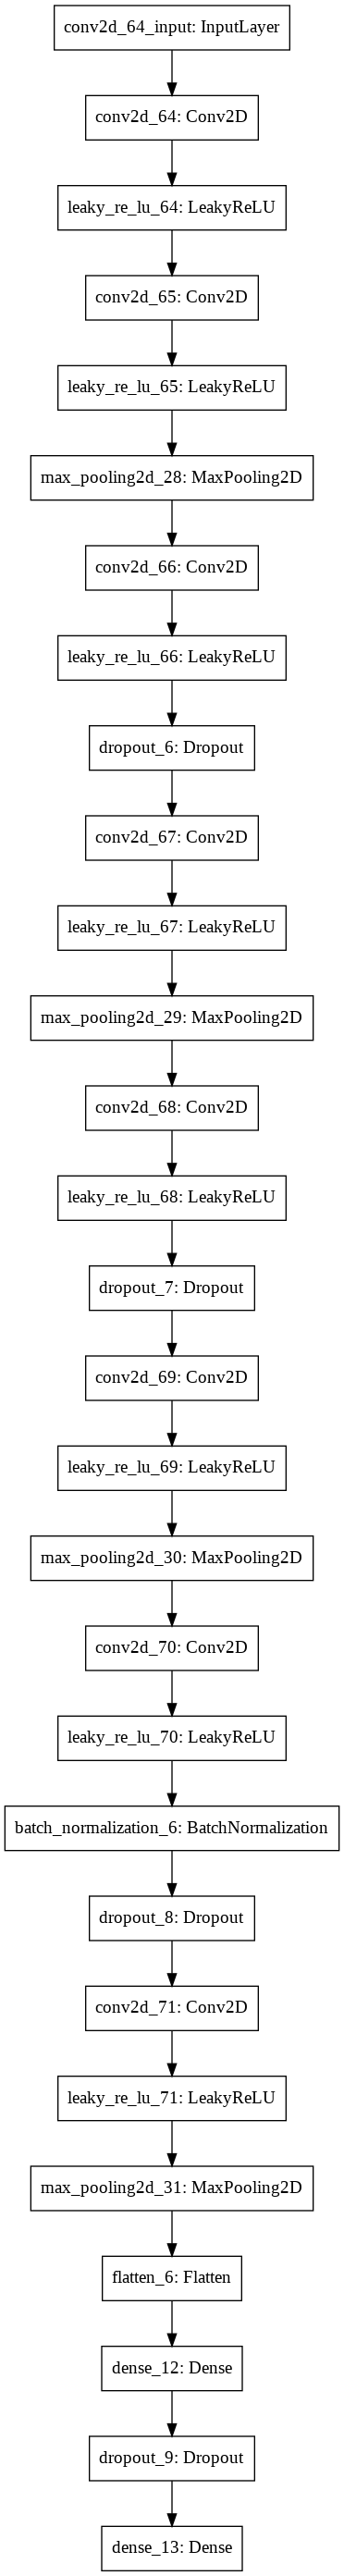

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model_cnn_ff, to_file='drive/My Drive/facial_keypoints_data/cnn__ff_rmse_2174.png')

## Preparing for transfer learning

In [24]:
model_cnn_ff.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 96, 96, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 96, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 96, 96, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 48, 48, 64)        18432     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 48, 48, 64)        0

We extract layers and weights up to layer "max_pooling2d_3", add few convolution layers, followed by flattening and dense layers.

In [25]:
last_layer = model_cnn_ff.get_layer('max_pooling2d_3')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# we first tried with freezing previous layers but that did not work well
# for layer in model.layers:
#   layer.trainable = False

last layer output shape:  (None, 6, 6, 128)


In [0]:
x =  Conv2D(128, (3,3), padding='same', activation='relu')(last_output)
x =  MaxPool2D(2,2)(x)
x =  Dropout(0.1)(x)

x =  Conv2D(128, (3,3), padding='same', activation='relu')(x)
x =  MaxPool2D(2,2)(x)
x =  Dropout(0.2)(x)

x =  Flatten()(x)
x =  Dense(512, activation='relu')(x)
x =  Dropout(0.2)(x)            
x =  Dense(128, activation='relu')(x)      

x =  Dense(30)(x)           


In [0]:
model_tf = Model( model_cnn_ff.input, x) 

In [0]:
# model_tf.summary()

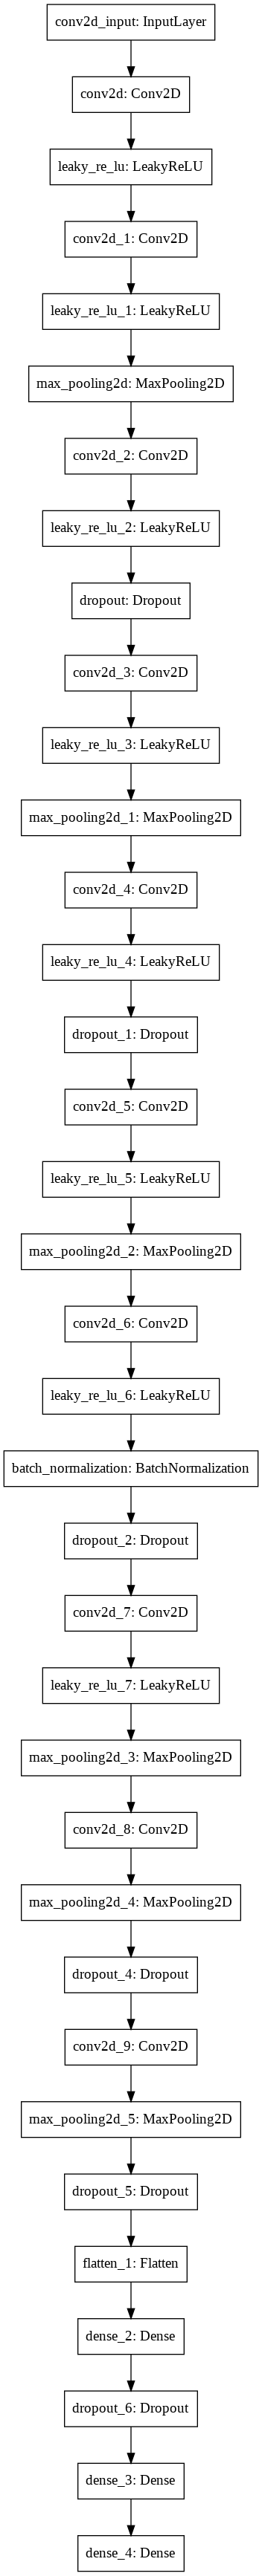

In [28]:
from tensorflow.keras.utils import plot_model
plot_model(model_tf, to_file='drive/My Drive/facial_keypoints_data/cnn_transfer_rmse_1556.png')

#### Preprocessing for all features

In [0]:
test_final['Image'] = test_final['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape((96,96)))
training_all_features['Image'] = training_all_features['Image'].apply(lambda x: np.fromstring(x, sep=' ').reshape((96,96)))

# TEST SET
# test_final = training_all_features.head(300)
X_test = np.vstack(test_final['Image'].values).reshape(test_final['Image'].values.shape[0], -1) / 255.
X_test = X_test.astype(np.float32)

y_test = test_final[test_final.columns[:-1]].values
y_test = (y_test - 48) / 48  # scale target coordinates to [-1, 1]
y_test = y_test.astype(np.float32)

# TRAIN SET
# training_all_features = training_all_features.tail(len(training_all_features) - 300)
X_train = np.vstack(training_all_features['Image'].values).reshape(training_all_features['Image'].values.shape[0], -1) / 255.
X_train = X_train.astype(np.float32)

y_train = training_all_features[training_all_features.columns[:-1]].values
y_train = (y_train - 48) / 48  # scale target coordinates to [-1, 1]
y_train = y_train.astype(np.float32)

### Augmenting Data

We developed our own augmenting function for flipping the images and coordinates horizontally, hovewer it did not improve the training. Actually it made it really worse - adding 300 augmented images results in increase in RMSE by 1 pixel. We suspect that it may mean that our network would work better on real world data (thanks to the regularization), but it did not work on images from test set, because test set consists of faces from the same angle and maybe faces are constructed in a way that flipping would make unrealistic faces?

Finally we decided to omit augmenting.

In [0]:
augmenting_df = training_all_features.sample(300)
XX = augmenting_df['Image'].values
yX = augmenting_df[training_all_features.columns[:-1]].values
yX = yX.astype(np.float32)

In [0]:
from sklearn.utils import shuffle
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables import Keypoint, KeypointsOnImage
from skimage import img_as_ubyte

def augment_data(X = XX,target = yX):
  for i, t in enumerate(X):
    for j, tt in enumerate(X[i]):
      for k, ttt in enumerate(X[i][j]):
        X[i][j][k] = X[i][j][k].astype(np.uint8)
      X[i][j] = X[i][j].astype(np.uint8)
    X[i] = X[i].astype(np.uint8)

  ia.seed(1)

  imgs_aug = []
  kpss_aug = []

  for j, (image, keypt) in enumerate(zip(X,target)):
    img = X[j]
    kps = KeypointsOnImage([
      Keypoint(keypt[0], keypt[1]),
      Keypoint(keypt[2], keypt[3]),
      Keypoint(keypt[4], keypt[5]),
      Keypoint(keypt[6], keypt[7]),
      Keypoint(keypt[8], keypt[9]),
      Keypoint(keypt[10], keypt[11]),
      Keypoint(keypt[12], keypt[13]),
      Keypoint(keypt[14], keypt[15]),
      Keypoint(keypt[16], keypt[17]),
      Keypoint(keypt[18], keypt[19]),
      Keypoint(keypt[20], keypt[21]),
      Keypoint(keypt[22], keypt[23]),
      Keypoint(keypt[24], keypt[25]),
      Keypoint(keypt[26], keypt[27]),
      Keypoint(keypt[28], keypt[29])],
      shape = (96,96))


    seq = iaa.Sequential([
        iaa.Fliplr(1.0)
    ])
    img_aug, kps_aug = seq(image=img, keypoints=kps)
    act_kps = []
    act_img = []
    for i in range(len(kps.keypoints)):
      act_kps.append(kps_aug.keypoints[i].x)
      act_kps.append(kps_aug.keypoints[i].y)
    imgs_aug.append(img_aug)
    kpss_aug.append(act_kps)

  img_arr = np.array(imgs_aug)
  key_arr = np.array(kpss_aug)

  # Create X_aug and y_aug which are same dimensions as training X and y

  X_aug = np.reshape(img_arr, (img_arr.shape[0], -1)) / 255.
  X_aug = X_aug.astype(np.float32)

  y_aug = (key_arr - 48) / 48
  X_aug, y_aug = shuffle(X_aug, y_aug, random_state=42)  # shuffle train data
  y_aug = y_aug.astype(np.float32)

  return (X_aug, y_aug)

In [0]:
X_aug, y_aug = augment_data(XX, yX)

In [0]:
X_train = np.concatenate((X_train, X_aug), axis = 0)
y_train = np.concatenate((y_train, y_aug), axis = 0)

### Reshaping data

In [30]:
X_train = X_train.reshape(-1,96,96,1)
X_test = X_test.reshape(-1,96,96,1)
print(X_train.shape)
print(X_test.shape)

(1840, 96, 96, 1)
(300, 96, 96, 1)


## Training transfer learning

This time we used Adam as an optimizer, since we had the weights in most layers initialized with "prior knowledge" and in result it worked better than SGD.

In [0]:
from tensorflow.keras.optimizers import Adam

model_tf.compile(loss = root_mean_squared_error,
              optimizer = Adam())

In [0]:
from tensorflow.keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 50)

In [0]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_loss') < 0.02 or logs.get('loss') < 0.01):
      print("\nReached target loss so cancelling training!")
      self.model.stop_training = True
    if epoch % 10 == 1:
      print(f"Epoch {epoch}")
      print(f"Loss :{logs.get('loss')} -- Val Loss: {logs.get('val_loss')}")
      print(f"")

callbacks = myCallback()

In [34]:
hist_cnn_af = model_tf.fit(X_train,
                        y_train,
                        epochs=500,
                        batch_size=128,
                        validation_split=0.1,
                        verbose = 0,
                        callbacks=[callbacks, es]
                     )

Epoch 1
Loss :0.10955028095539066 -- Val Loss: 0.1329846291438393

Epoch 11
Loss :0.0634930889495617 -- Val Loss: 0.06778731553450874

Epoch 21
Loss :0.04577748326287753 -- Val Loss: 0.04359461820643881

Epoch 31
Loss :0.036876685503456325 -- Val Loss: 0.03382461469458497

Epoch 41
Loss :0.03359896455697967 -- Val Loss: 0.030636238825062046

Epoch 51
Loss :0.0312864071181143 -- Val Loss: 0.029194633921851284

Epoch 61
Loss :0.030398788317534082 -- Val Loss: 0.030094646565292194

Epoch 71
Loss :0.027870886693686103 -- Val Loss: 0.02802756201961766

Epoch 81
Loss :0.02673246283174137 -- Val Loss: 0.028040339603372242

Epoch 91
Loss :0.025719869854873505 -- Val Loss: 0.028011238445406376

Epoch 101
Loss :0.02501968684007868 -- Val Loss: 0.027782369405031204

Epoch 111
Loss :0.024565973791523255 -- Val Loss: 0.02815843567900036

Epoch 121
Loss :0.023648648932216246 -- Val Loss: 0.027843232793004616

Epoch 131
Loss :0.023392585317653734 -- Val Loss: 0.027536722952904907

Epoch 141
Loss :0.0

### Evaluation

In [35]:
score = model_tf.evaluate(X_test, y_test, verbose=0)
print('Test RMSE:', score)
# print('Test MAE:', score[1])
print('Rescaled RMSE:', score*48)

Test RMSE: 0.02961113639175892
Rescaled RMSE: 1.4213345468044283


Success! We managed to achieve RMSE on test set below 1.5!

### Loss visualization

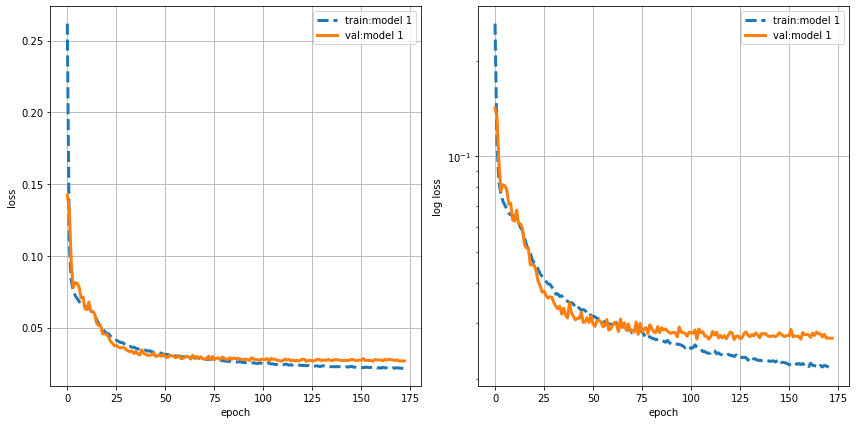

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss(hist,name,plt):

    loss = hist['loss']
    val_loss = hist['val_loss']
        
    plt.plot(loss,"--", linewidth=3, label="train:"+name)
    plt.plot(val_loss, linewidth=3, label="val:"+name)

plt.figure(figsize=(12,6))

plt.subplot(1, 2, 1)
plot_loss(hist_cnn_af.history,"model 1",plt)
plt.legend()
plt.grid()
plt.xlabel("epoch")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plot_loss(hist_cnn_af.history,"model 1",plt)
plt.legend()
plt.grid()
plt.yscale("log")
plt.xlabel("epoch")
plt.ylabel("log loss")

plt.savefig('drive/My Drive/CNN_transfer_loss.png', bbox_inches='tight')
plt.tight_layout()
plt.show()

As we can see the network in some epoch underfitted the training set, however after 75 epoch it started to overfitt the training data and in result our callback and early stopping stopped the training process on 173th epoch.

### Saving model architecture and weights

In [0]:
save_model(model_tf,"model_cnn_transfer_1421")
model_tf = load_model("model_cnn_transfer_1421")

In [0]:
# from keras.models import load_model

# model_tf = load_model("model_cnn_transfer_1556")

### Plotting predicted vs real

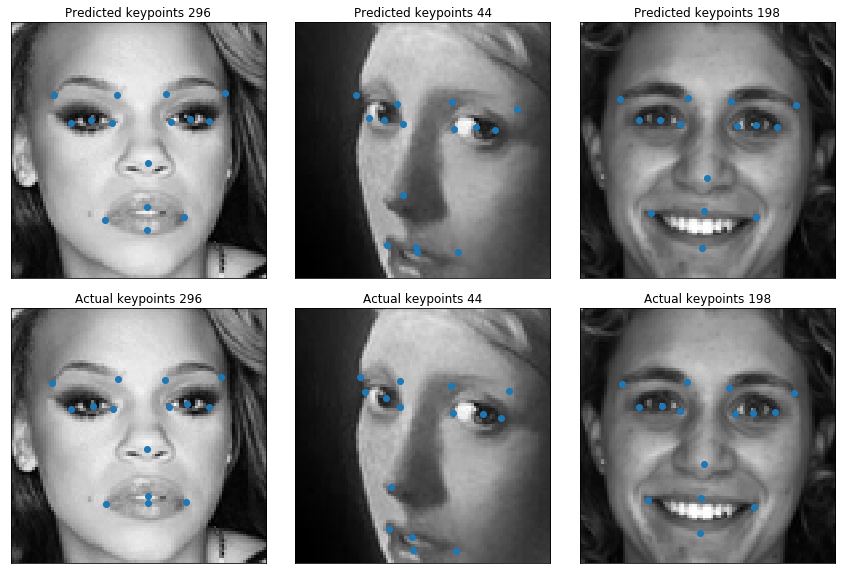

In [42]:
def plot_sample(X,y,axs):
    axs.imshow(X.reshape(96,96),cmap="gray")
    axs.scatter(48*y[0::2]+ 48,48*y[1::2]+ 48)

fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.13,wspace=0.0001,
                    left=0,right=1,bottom=0, top=1)
Npicture = 9
count = 1
picture_id = [296,44,198]
y_eval = model_tf.predict(X_test)

for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_eval[ipic],ax)
    ax.set_title("Predicted keypoints "+ str(ipic))
    count += 1


for ipic in picture_id:
    ax = fig.add_subplot(Npicture/3 , 3, count,xticks=[],yticks=[])        
    plot_sample(X_test[ipic],y_test[ipic],ax)
    ax.set_title("Actual keypoints "+ str(ipic))
    count += 1

plt.tight_layout()
plt.savefig('drive/My Drive/CNN_faces_test_eval_transfer_learning.png', bbox_inches='tight')
plt.show()